In [141]:
import os
import pickle
import re
import unicodedata as ud
from pprint import pprint

import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import pymongo
import spacy
from dotenv import load_dotenv
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from sklearn import datasets, svm
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from helpers import (british_to_american, connect_to_db, decontracted,
                     display_topics, remove_hashtags_mentions_urls,
                     restore_spaced_title)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from collections import defaultdict

## Connect to database - Load data to pandas

## PREPROCESSING

In [3]:
def cleaning(text):
    """

    """
    br_am = pickle.load(open("british_to_american.pkl", 'rb'))
    r_ = "([a-zA-Z]+)"

    text = restore_spaced_title(text)
    text = remove_hashtags_mentions_urls(text)

    text = ' '.join([e for e in re.findall(
        r_, text)]).strip()
    
    text = ud.normalize('NFKD', text)
    text = decontracted(text)
    text = british_to_american(text)

    return text

In [4]:
def preprocessing(text):        
    sent = []
    doc = nlp(text)
    
    for word in doc:
        sent.append(word.lemma_)
    
    return " ".join(sent)
    
#df['pre_cleaned_text'] = df['content'].apply(cleaning)
#df['lemmatized_text'] = df['pre_cleaned_text'].apply(preprocessing)
#df['cleaned_lemmatized_text'] = df['lemmatized_text'].str.replace('-PRON-', '')

In [5]:
#pickle.dump(all_stopwords, open('stopword.pkl', 'wb'))
nlp = spacy.load('en_core_web_lg')
all_stopwords = pickle.load(open('stopword.pkl', 'rb'))

In [245]:
def stemming(text):
    stemmer = nltk.stem.SnowballStemmer('english', ignore_stopwords=True)
    stemmer.stopwords = all_stopwords
    
    stemmed_words = []
    
    for w in text.split():
        stemmed_words.append(stemmer.stem(w))
        
    text = ' '.join(stemmed_words)
        
    return text

In [241]:
df = pd.read_csv("../data/cleaned_text.csv", index_col='Unnamed: 0').replace(np.nan, '')

df.tail()

,_id,account,post_id,likes,comments,date,content,hashtags,number_hashtags,img_text,number_emojis,mentions,emoji_terms,pre_cleaned_text,url_email,all_content,sentiment,year,month,day
14834,5f3873dc9ff725ae35d79ed2,yasminecheyenne,CD1O-6VJ2dm,716,30,2020-08-13 09:50:19,i’m so excited to share my collaboration with ...,,0,but here’s a f » lee that you deserve « W Jenn...,5.0,the_qi_ greetabl palermobody,raising hands hugging face medium dark skin to...,i am so excited to share my collaboration with...,,i’m so excited to share my collaboration with ...,0.9945,2020,8,13
14835,5f3873dd9ff725ae35d79ed3,yasminecheyenne,CD354l1pXke,2804,32,2020-08-14 10:43:41,speak it out loud loves! 🗣🗣🗣\n,,0,Caleta sree vueB lela etaleyse Vibe ntoleysert...,3.0,,speaking head,speak it out loud loves!,,speak it out loud loves! 🗣🗣🗣\n,0.6114,2020,8,14
14836,5f3873de9ff725ae35d79ed4,yasminecheyenne,CD6jGmrpRi0,909,17,2020-08-15 11:22:20,here’s to a weekend with some time for you x\n,,0,Caleta sree i deserve time for me. i don’t hav...,0.0,,,here is to a weekend with some time for you x,,here’s to a weekend with some time for you x\n,0.0000,2020,8,15
14837,5f3889259ff725ae35d79ed5,minaa_b,CD1RoGRp9MF,6735,57,2020-08-13 10:13:25,Because self-care is community care.\n—•\nComm...,,0,"LIVE IN\nyouR LIGHT, AND\nALSO SHARE YyouR LIG...",0.0,,,Because self-care is community care. Community...,,Because self-care is community care.\n—•\nComm...,0.7096,2020,8,13
14838,5f3889269ff725ae35d79ed6,minaa_b,CD39wecpZfH,1747,24,2020-08-14 11:17:32,"#AD - During this time of collective healing, ...",ad,1,,0.0,bevocal.speakup,,"During this time of collective healing, I have...",,"#AD - During this time of collective healing, ...",-0.7911,2020,8,14


In [246]:
#df['lemmatized_text'] = df['pre_cleaned_text'].apply(preprocessing)
#df['cleaned_lemmatized_text'] = df['lemmatized_text'].str.replace('-PRON-', '')
df['cleaned_stemmed_text'] = df['cleaned_lemmatized_text'].apply(stemming)

df.to_csv("../data/cleaned_text.csv")

In [269]:
len(df.content.min())

4

In [270]:
0.01 * 100

1.0

In [271]:
stemming('casually')

'casual'

In [247]:
params = {
    'vectorizer': {
        'analyzer': 'word',
        'stop_words': all_stopwords,
        'ngram_range': (1, 1),
        'token_pattern': '[a-z]{3,}',
        'min_df': 0.01,
        'lowercase': True
    },
    'raw_documents': df['cleaned_stemmed_text'],
    'components': 4,
}

# CountVectorizer

In [279]:
cv = CountVectorizer(**params['vectorizer'])
X_cv = cv.fit_transform(raw_documents=params['raw_documents'])

cv_doc_word = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
cv_doc_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14834,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
from sklearn.utils.extmath import randomized_svd

In [250]:
k = 80
U, Sigma, VT = randomized_svd(X_cv, 
                              n_components=k,
                              n_iter=5,
                              random_state=None)

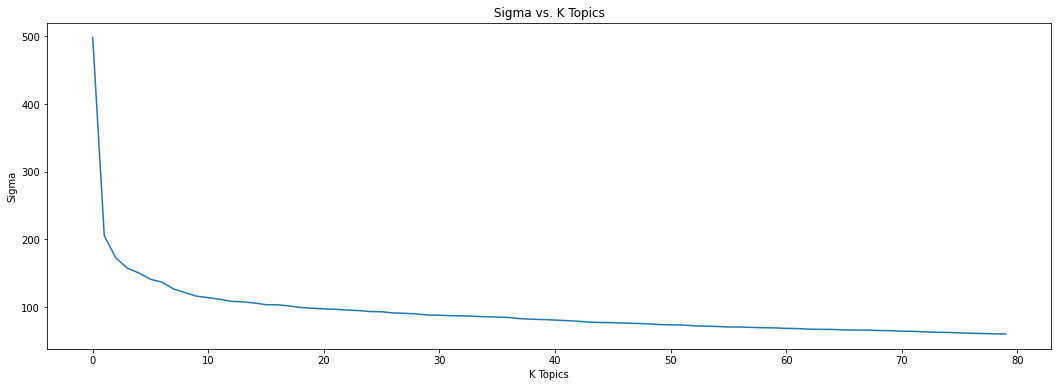

In [251]:
plt.figure(figsize=(18, 6))
plt.title("Sigma vs. K Topics")
plt.ylabel("Sigma")
plt.xlabel("K Topics")
sns.lineplot(range(k), Sigma)
plt.savefig("sigma_topics_cv.png");

In [254]:
list(zip(Sigma, range(50)))[:20]

[(498.42858810154996, 0),
 (205.69952359893483, 1),
 (172.72227237948496, 2),
 (157.54455867645873, 3),
 (150.57651873755592, 4),
 (141.23399777126716, 5),
 (136.9327703347962, 6),
 (126.84723775549277, 7),
 (121.49844732306126, 8),
 (116.19743427419306, 9),
 (114.06087511280843, 10),
 (111.6842845728781, 11),
 (108.62553080468285, 12),
 (107.91096907663815, 13),
 (106.17963623495072, 14),
 (103.67367525701655, 15),
 (103.54415801081711, 16),
 (101.76376831869742, 17),
 (99.53996830393673, 18),
 (98.50001690504516, 19)]

### Ideal number of topics for CountVectorizer
(103.59593492814827, 15),

(103.50458572864622, 16),

# TF-IDF

In [255]:
tfidf = TfidfVectorizer(**params['vectorizer'])
X_tfidf = tfidf.fit_transform(raw_documents=params['raw_documents'])

tfidf_doc_word = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names())
tfidf_doc_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14834,0.0,0.0,0.0,0.0,0.000000,0.0,0.114578,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.101823
14835,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14836,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14837,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [256]:
k = 80
U, Sigma, VT = randomized_svd(X_tfidf, 
                              n_components=k,
                              n_iter=5,
                              random_state=None)

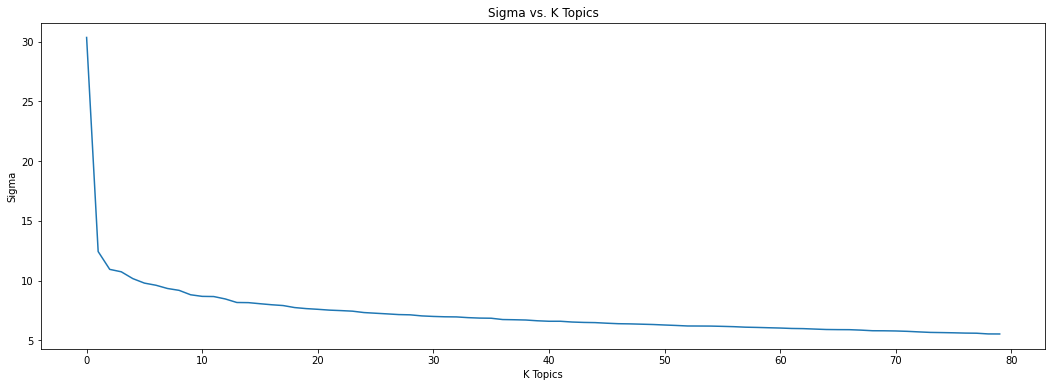

In [257]:
plt.figure(figsize=(18, 6))
plt.title("Sigma vs. K Topics")
plt.ylabel("Sigma")
plt.xlabel("K Topics")
sns.lineplot(range(k), Sigma)
plt.savefig("sigma_topics_tfidf.png");

In [258]:
list(zip(Sigma, range(50)))[:20]

[(30.352597126355523, 0),
 (12.429985898044023, 1),
 (10.938329601890961, 2),
 (10.734602470668024, 3),
 (10.163194745068266, 4),
 (9.788166832871973, 5),
 (9.608551688444015, 6),
 (9.336453862878248, 7),
 (9.182138648249364, 8),
 (8.811034306625048, 9),
 (8.678115005484708, 10),
 (8.663032264684018, 11),
 (8.460333551021193, 12),
 (8.164761528078307, 13),
 (8.152585963802101, 14),
 (8.062014693085565, 15),
 (7.9763084517845355, 16),
 (7.9089547025544364, 17),
 (7.739700260451006, 18),
 (7.652741916767693, 19)]

### Ideal number of topics for TF-IDF
(10.9401278786008, 2),

(10.732035945376614, 3),

(10.166535272791887, 4),

# LSA (Latent Semantic Analysis)

### CV

## TF-IDF

In [128]:
lsa_tfidf = TruncatedSVD(params['components'])

tfidf_topic = lsa_tfidf.fit_transform(tfidf_doc_word)
lsa_tfidf.explained_variance_ratio_

array([0.01333755, 0.01135577, 0.00866685, 0.0083481 ])

In [129]:
tfidf_topic_word = pd.DataFrame(lsa_tfidf.components_.round(3),
             index = [f"component_{c + 1}" for c in range(params['components'])],
             columns = tfidf.get_feature_names())

tfidf_topic_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
component_1,0.020,0.016,0.037,0.010,0.023,0.044,0.015,0.015,0.009,0.021,...,0.035,0.025,0.031,0.042,0.030,0.007,0.020,0.014,0.011,0.026
component_2,0.003,-0.013,-0.003,-0.001,-0.029,0.022,-0.012,-0.005,-0.002,-0.013,...,-0.010,-0.002,0.007,-0.004,0.015,-0.004,0.005,0.006,-0.005,-0.014
component_3,-0.000,0.010,-0.006,-0.004,0.011,-0.026,0.017,0.007,0.007,-0.003,...,0.031,0.006,-0.038,0.030,-0.046,0.007,-0.005,-0.004,0.020,0.104
component_4,0.030,0.009,0.012,-0.000,0.040,0.023,-0.007,-0.002,-0.004,0.008,...,0.043,-0.034,0.002,-0.077,0.001,-0.005,-0.008,-0.008,0.006,-0.079


In [131]:
display_topics(lsa_tfidf, tfidf.get_feature_names(), 15)


Topic  1
love, feel, peopl, relationship, need, get, time, way, know, self, work, want, thing, life, make

Topic  2
love, let, great, beauti, choos, fear, give, partner, keep, stori, never, show, receiv, happi, someon

Topic  3
self, love, care, trauma, mind, heal, child, bodi, mental, emot, free, today, health, practic, your

Topic  4
boundari, relationship, love, emot, child, healthi, set, self, parent, feel, partner, need, behavior, inner, adult


# TOPICS FOR LSA— CV vs. TF-IDF

### CV
Topic  1
feel, love, peopl, need, relationship, get, way, time, know, work, make, want, one, may, like

Topic  2
love, relationship, great, let, partner, give, choos, fear, receiv, beauti, keep, never, show, stori, one

Topic  3
feel, love, emot, bodi, may, like, self, safe, experi, trauma, child, shame, respons, nervous, inner

Topic  4
relationship, self, emot, heal, child, trauma, work, parent, partner, learn, inner, ego, becom, conscious, pattern

Topic  5
relationship, feel, partner, need, person, boundari, want, healthi, may, someon, ask, coupl, conflict, communic, set


### IF-IDF
Topic  1
love, feel, peopl, relationship, need, get, time, way, know, self, work, want, thing, life, make

Topic  2
love, let, great, beauti, choos, fear, give, keep, partner, stori, never, show, receiv, happi, someon

Topic  3
self, love, trauma, care, mind, emot, child, heal, bodi, free, your, today, mental, practic, inner

Topic  4
boundari, relationship, emot, love, child, healthi, parent, set, feel, self, partner, need, inner, adult, behavior

Topic  5
boundari, therapi, care, therapist, help, today, set, health, mental, remind, peopl, healthi, link, friend, bio

# NMF (Non-negative Matrix Factorization)

## CV

In [286]:
cv = CountVectorizer(**params['vectorizer'])
X_cv = cv.fit_transform(raw_documents=params['raw_documents'])

cv_doc_word = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
cv_doc_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14834,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
nmf_cv_model = NMF(10)
nmf_doc_topic = nmf_cv_model.fit_transform(cv_doc_word)

/Users/faustina/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [288]:
cv.get_feature_names()

['abandon',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'account',
 'achiev',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'adapt',
 'add',
 'addict',
 'address',
 'adult',
 'advic',
 'affect',
 'affirm',
 'afraid',
 'age',
 'ago',
 'agre',
 'align',
 'aliv',
 'allow',
 'almost',
 'alon',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'amaz',
 'amount',
 'anger',
 'angri',
 'anoth',
 'answer',
 'anxieti',
 'anxious',
 'anyon',
 'anyth',
 'anyway',
 'apart',
 'apolog',
 'appear',
 'appli',
 'appreci',
 'approach',
 'area',
 'around',
 'art',
 'ask',
 'aspect',
 'assum',
 'attach',
 'attempt',
 'attent',
 'attract',
 'authent',
 'avail',
 'avoid',
 'awaken',
 'awar',
 'away',
 'babi',
 'back',
 'bad',
 'balanc',
 'base',
 'bear',
 'beauti',
 'becom',
 'bed',
 'begin',
 'behav',
 'behavior',
 'behind',
 'being',
 'belief',
 'believ',
 'belong',
 'benefit',
 'betray',
 'beyond',
 'big',
 'bio',
 'bit',
 'black',
 'blame',
 'bless',
 'blind',
 'block',
 '

In [290]:
nmf_cv_model.components_.shape

(10, 912)

In [292]:
len(cv.get_feature_names())

912

In [293]:
nmf_cv_topic_word = pd.DataFrame(nmf_cv_model.components_.round(3),
             index = [f"component_{c + 1}" for c in range(10)],
             columns = cv.get_feature_names())

nmf_cv_topic_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
component_1,0.256,0.066,0.218,0.097,0.000,1.107,0.000,0.072,0.051,0.368,...,0.534,0.358,0.633,0.414,0.503,0.000,0.361,0.133,0.074,0.109
component_2,0.066,0.000,0.187,0.000,0.000,0.192,0.004,0.000,0.021,0.000,...,0.059,0.014,0.063,0.000,0.060,0.000,0.080,0.026,0.000,0.054
component_3,0.022,0.068,0.252,0.000,0.000,0.000,0.028,0.000,0.016,0.149,...,0.000,0.023,0.178,0.000,0.000,0.038,0.045,0.000,0.000,0.000
component_4,0.290,0.144,0.052,0.000,0.000,0.365,0.090,0.225,0.154,0.135,...,0.389,0.116,0.000,0.199,0.000,0.026,0.053,0.116,0.347,0.123
component_5,0.256,0.073,0.045,0.037,0.606,0.252,0.000,0.063,0.000,0.000,...,0.320,0.000,0.069,0.000,0.100,0.010,0.067,0.014,0.000,0.047
component_6,0.161,0.000,0.268,0.000,0.000,0.000,0.090,0.000,0.000,0.164,...,0.153,0.000,0.000,0.000,0.278,0.000,0.015,0.000,0.109,0.003
component_7,0.000,0.011,0.097,0.031,0.035,0.197,0.034,0.033,0.006,0.000,...,0.000,0.000,0.285,0.053,0.046,0.002,0.006,0.007,0.000,0.000
component_8,0.030,0.105,0.443,0.041,0.573,0.000,0.261,0.052,0.030,0.127,...,0.407,0.008,0.000,0.287,0.000,0.017,0.057,0.000,0.000,0.159
component_9,0.000,0.059,0.258,0.096,0.000,0.000,0.112,0.123,0.058,0.000,...,0.000,0.345,0.178,0.728,0.287,0.075,0.113,0.173,0.000,0.000
component_10,0.112,0.170,0.000,0.019,0.260,0.096,0.001,0.000,0.001,0.009,...,0.398,0.045,0.000,0.102,0.000,0.013,0.000,0.000,0.091,0.004


In [297]:
topic_names_ = ['Healing Journey', 
                'Intimacy in Relationships', 
                'Asking/Looking for Help', 
                'Inner-Work', 
                'Healthy Relationships', 
                'Communication', 
                'Otherness', 'Trauma', 
                'Actions', 
                'Reparenting']

In [298]:
display_topics(nmf_cv_model, cv.get_feature_names(), 15, topic_names=topic_names_)


Topic: ' Healing Journey '
life, let, chang, stori, thing, way, pain, one, see, keep, fear, come, choos, take, time

Topic: ' Intimacy in Relationships '
love, give, great, fear, way, someon, one, receiv, partner, let, choos, know, beauti, show, part

Topic: ' Asking/Looking for Help '
feel, like, may, make, safe, way, experi, someth, bodi, someon, share, say, hurt, realli, help

Topic: ' Inner-Work '
self, ego, work, care, practic, see, awar, inner, child, part, learn, becom, take, mind, compass

Topic: ' Healthy Relationships '
relationship, partner, may, healthi, person, work, one, learn, boundari, attach, conflict, coupl, pattern, dynam, mean

Topic: ' Communication '
need, boundari, ask, take, meet, space, set, honor, want, order, someth, connect, hear, understand, part

Topic: ' Otherness '
peopl, person, know, life, boundari, someon, think, make, want, mean, way, understand, believ, share, around

Topic: ' Trauma '
trauma, heal, bodi, system, experi, work, respons, nervous, may

## TF-IDF

In [132]:
nmf_tfidf_model = NMF(params['components'])
nmf_doc_topic = nmf_tfidf_model.fit_transform(tfidf_doc_word)

In [133]:
nmf_tfidf_topic_word = pd.DataFrame(nmf_tfidf_model.components_.round(3),
             index = [f"component_{c + 1}" for c in range(params['components'])],
             columns = tfidf.get_feature_names())

nmf_tfidf_topic_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
component_1,0.064,0.037,0.161,0.054,0.009,0.244,0.031,0.065,0.036,0.099,...,0.066,0.144,0.234,0.210,0.218,0.021,0.123,0.087,0.019,0.000
component_2,0.032,0.000,0.048,0.007,0.000,0.088,0.003,0.001,0.009,0.000,...,0.043,0.007,0.016,0.027,0.016,0.002,0.023,0.022,0.012,0.037
component_3,0.048,0.095,0.108,0.020,0.136,0.031,0.104,0.056,0.046,0.082,...,0.205,0.069,0.000,0.156,0.000,0.043,0.031,0.010,0.085,0.338
component_4,0.082,0.035,0.044,0.014,0.132,0.063,0.014,0.027,0.000,0.018,...,0.069,0.000,0.007,0.000,0.044,0.011,0.000,0.007,0.000,0.000


In [135]:
display_topics(nmf_tfidf_model, tfidf.get_feature_names(), 15)


Topic  1
peopl, get, need, thing, know, want, life, time, let, feel, make, say, way, chang, one

Topic  2
love, self, great, partner, one, give, beauti, fear, receiv, show, heart, relationship, someon, happi, much

Topic  3
self, feel, emot, trauma, heal, mind, bodi, care, child, experi, mental, work, practic, help, free

Topic  4
relationship, boundari, healthi, set, need, partner, peopl, may, person, famili, respect, import, parent, communic, dynam


# TOPICS FOR NMF— CV vs. TF-IDF

### CV
Topic  1
peopl, get, need, know, want, thing, life, time, make, way, let, one, take, person, say

Topic  2
love, self, give, fear, great, let, way, one, someon, part, partner, receiv, keep, choos, see

Topic  3
feel, like, may, emot, make, experi, safe, way, bodi, need, someth, help, say, someon, share

Topic  4
self, heal, trauma, emot, child, work, experi, bodi, parent, see, learn, ego, practic, inner, mind

Topic  5
relationship, partner, may, person, healthi, boundari, work, need, one, want, learn, coupl, attach, conflict, pattern


### IF-IDF
Topic  1
peopl, get, need, thing, want, know, let, life, time, say, make, feel, way, chang, person

Topic  2
love, self, partner, relationship, great, give, one, receiv, beauti, show, fear, heart, someon, part, brave

Topic  3
feel, emot, self, trauma, heal, child, bodi, experi, parent, inner, may, respons, system, work, becom

Topic  4
boundari, relationship, set, healthi, need, peopl, partner, respect, famili, may, import, person, communic, help, dynam

Topic  5
today, therapi, therapist, mental, health, help, day, remind, mind, link, free, care, bio, thank, share

# LDA (Latent Dirichlet Allocation)

## CV

## IF-IDF

In [136]:
lda_tfidf_model = LatentDirichletAllocation(n_components=params['components'], # Number of topics
                                            learning_method='online',
                                            random_state=0,       
                                            n_jobs = -1  # Use all available CPUs
                                           )

lda_tfidf_output = lda_tfidf_model.fit_transform(X_tfidf)

In [26]:
lda_tfidf_topic_word = pd.DataFrame(lda_tfidf_model.components_.round(3),
             index = [f"component_{c + 1}" for c in range(params['components'])],
             columns = tfidf.get_feature_names())

lda_tfidf_topic_word

,abandon,abil,abl,absolut,abus,accept,access,account,achiev,acknowledg,...,wound,write,wrong,year,yes,yesterday,yet,you,young,your
component_1,0.201,0.202,0.203,0.202,0.202,0.201,0.218,0.217,0.205,0.202,...,0.202,15.479,0.200,21.496,0.205,0.216,3.335,0.580,0.203,0.207
component_2,0.201,0.202,0.202,0.207,0.201,0.203,0.224,0.203,0.202,0.202,...,0.201,0.203,0.202,0.204,0.210,0.207,0.205,0.202,0.202,0.208
component_3,17.447,34.582,58.099,14.924,68.557,34.586,36.195,31.219,20.957,26.114,...,50.407,28.107,26.946,51.475,16.303,18.518,16.237,12.475,19.641,109.621
component_4,35.020,21.761,60.442,18.573,13.500,98.820,19.177,24.448,12.984,40.188,...,52.519,41.522,65.343,64.801,81.679,10.645,42.125,35.287,20.666,34.817
component_5,0.200,0.204,0.202,0.204,0.201,0.202,0.202,0.205,0.206,0.202,...,0.200,0.207,0.201,15.910,0.202,0.206,0.203,0.208,0.202,0.216


In [137]:
display_topics(lda_tfidf_model, tfidf.get_feature_names(), 15)


Topic  1
today, remind, thank, happi, link, check, via, free, day, bio, love, book, black, tag, weekend

Topic  2
therapi, mental, trauma, health, therapist, bodi, anxieti, help, brain, system, stress, depress, nervous, care, cope

Topic  3
love, get, feel, let, need, life, time, know, peopl, one, want, thing, way, heal, make

Topic  4
feel, relationship, peopl, self, emot, boundari, need, may, way, like, make, person, thing, say, child


# TOPICS FOR LDA— CV vs. TF-IDF

### CV
Topic  1
love, let, life, one, choos, get, give, good, way, keep, fear, know, great, stay, never

Topic  2
feel, stori, get, thing, chang, happen, life, take, pain, time, moment, let, come, someth, need

Topic  3
self, heal, trauma, emot, feel, child, experi, work, parent, becom, respons, bodi, see, inner, may

Topic  4
relationship, need, feel, peopl, want, person, may, know, partner, someon, like, boundari, say, mean, get

Topic  5
help, feel, time, like, mental, therapi, therapist, post, use, share, thought, health, mind, day, think


### IF-IDF
Topic  1
link, bio, via, book, check, communiti, read, new, post, join, get, thank, full, share, woman

Topic  2
remind, therapi, tag, therapist, season, blog, friend, today, gentl, disord, session, lesson, favorit, rise, beauti

Topic  3
feel, self, emot, peopl, relationship, trauma, help, mind, may, heal, work, experi, like, need, bodi

Topic  4
love, feel, need, peopl, get, relationship, want, know, let, thing, time, way, life, make, say

Topic  5
happi, today, black, weekend, thank, day, love, grate, soul, morn, affirm, joy, resourc, rest, folk

# Topics

In [182]:
label = df['content'].index

In [157]:
doc_word = tfidf.fit_transform(df['content'])
doc_topic = nmf_tfidf_model.fit_transform(doc_word)

In [214]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = label,
                             columns=['topic{}'.format(i + 1) for i in range(4)])

df['top_topic'] = doc_topic_nmf.idxmax(axis=1)

In [215]:
doc_topic_nmf

,topic1,topic2,topic3,topic4
0,0.00000,0.02396,0.00984,0.07354
1,0.01361,0.00000,0.00675,0.00789
2,0.01468,0.00000,0.02275,0.00000
3,0.01474,0.00000,0.00732,0.01408
4,0.00406,0.00677,0.00576,0.05082
...,...,...,...,...
14834,0.06289,0.00000,0.00000,0.00957
14835,0.00244,0.00000,0.00041,0.00008
14836,0.02747,0.00000,0.00000,0.00979
14837,0.02099,0.00000,0.00066,0.00879


In [217]:
df['top_topic'].value_counts()

topic1    11217
topic4     2412
topic3      639
topic2      571
Name: top_topic, dtype: int64

# CountVectorizer + NMF

In [299]:
doc_word = cv.fit_transform(df['content'])
doc_topic = nmf_cv_model.fit_transform(doc_word)

In [300]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = label,
                             columns=topic_names_)

doc_topic_nmf.idxmax(axis=1)

0                  Reparenting
1        Healthy Relationships
2        Healthy Relationships
3        Healthy Relationships
4                  Reparenting
                 ...          
14834               Inner-Work
14835                  Actions
14836          Healing Journey
14837                  Actions
14838                Otherness
Length: 14839, dtype: object

In [301]:
doc_topic_nmf.idxmax(axis=1).value_counts()

Healing Journey              4325
Intimacy in Relationships    1921
Reparenting                  1763
Otherness                    1387
Inner-Work                   1329
Healthy Relationships        1069
Asking/Looking for Help       813
Trauma                        810
Communication                 772
Actions                       650
dtype: int64

In [302]:
t = ["I want to learn more about myself, I had a tough childhood but I got out of it and I'm in a relationship right now. I haven't done therapy yet"]
vt = cv.fit_transform(t)
tt = nmf_cv_model.fit_transform(vt)

for i in pairwise_distances(tt, doc_topic_nmf, metric='cosine').argsort()[0][:5]:
    print("Post from:".upper(), df.iloc[i]['account'])
    print(df.iloc[i]['content'], '\n\n')

POST FROM: dr.marielbuque
Your soul needs time.

It took time to feel the hurt. And it will take time to shed it. Time is a precious gift that coincides with healing to create a new version of us. You need time, just as much as you need healing.

So take all the time you need. We will be here waiting.
 


POST FROM: thebraincoach
A depressed negative feeling is experienced differently by everyone. Chest pain or heaviness is a common feeling described by most of us going through this experience. It can feel like our chest is tightening or aching. 
It may be extremely difficult to get out of this feeling sometimes and just getting out of bed might seem like a daunting task. However, to reduce symptoms of depression, it is important that you: 
1. Do things that make you feel good (such as pick up a former hobby or sport you used to like). Take it slow at first and work your way up. 
2. Reach out and stay connected with people who make you feel safe and cared for (such as a friend, family 

In [303]:
t = ["I wanted to take back my diagnosis and keep that can of worms closed shut. But repressing all that stuff made me physically ill. It made my brain stop working. And eventually I had a nervous breakdown so bad my consciousness left my brain and the world looked unreal. "]
vt = cv.fit_transform(t)
tt = nmf_cv_model.fit_transform(vt)

for i in pairwise_distances(tt, doc_topic_nmf, metric='cosine').argsort()[0][:5]:
    print("Post from:".upper(), df.iloc[i]['account'])
    print("Post from:".upper(), df.iloc[i]['post_id'])
    print("Post from:".upper(), df.iloc[i]['post_id'])
    print(df.iloc[i]['content'], '\n\n')

POST FROM: the.holistic.psychologist
POST FROM: BqyIXWTg6Yr
-
Time for some real talk (with lots of love behind it.)
-
You know where to start. We all do. We know the habits that lead to highest versions of ourselves. We know the daily rituals we want to have.
-
We just don’t trust ourselves. We’ve let ourselves down countless times. Made commitments and haven’t kept them. Betrayed ourselves. Just as you don’t trust a partner who’s betrayed trust, you don’t trust yourself.
-
There’s this idea that self worth and self esteem can be stated and we will change the narrative in our minds. “I am worthy” means nothing until you prove to yourself that you’re worthy. “I love myself” means nothing until you show up to love yourself day after day. That’s how it works. It’s earned.
-
I know my worth because I trust myself. I know I’ll follow through. I’ll wake up early and go to bed early. I’ll eat well and meditate. I’ll set up time to create. I’ll deliver for my clients. I’ll get to the gym and 

In [321]:
t = ["I’ve been talking to a new person that I really like and see myself being friends with and just connect with. I want him to know who I am so I’m trying to explain my past and what I went through, but I end up crying about it because it was a lot of bad negative stuff that really hurt me. Is this healthy to do? Like do I just need to forget the past or whatever? I know it’s probably best to feel these things without any judgement right? It’s just crazy I’m crying about something that happened few years ago, like I know it’s not stupid but I just feel stupid about feeling the way I do which I’m trying to feel anymore. My friend went through family problems too so it makes me really understand what he went through, and idk why it’s always the ones that dealt with family problems that I connect with the most. Is that normal?"]
vt = cv.fit_transform(t)
tt = nmf_cv_model.fit_transform(vt)

for i in pairwise_distances(tt, doc_topic_nmf, metric='cosine').argsort()[0][:5]:
    print("Post from:".upper(), df.iloc[i]['account'])
    print("Post from:".upper(), df.iloc[i]['post_id'])
    #print("Post from:".upper(), df.iloc[i]['post_id'])
    print(df.iloc[i]['content'], '\n\n')

POST FROM: lizlistens
POST FROM: BzoJAmrAMWT
The legacy of wounding - oof. It’s a big one. It’s why generationally we see the same wounds being handed down over and over again OR the phenomenon of trying so hard to make it different that we overcompensate and in doing so create new wounds.
.
Harville Hendrix writes about the legacy of wounding and how it continues without self awareness.
.
Even when we think we are doing things differently, we might still be controlled by our “wound”.
.
Take the example of feeling deprived of “things” as a child. Perhaps you wished that you were given toys or offered experiences and for whatever reason you weren’t. Maybe you equated this to being unloved or maybe it made you feel less than.
.
You might remember never experiencing a birthday party or having parents that wished they could have done more but couldn’t because they just didn’t have the means.
.
This might have hurt you deeply and perhaps you carry on the deprivation by saying things like “I

In [327]:
t = ["Just wanted to drop in and remind you to check on your breath! If you’re breathing shallow take a minute and take some deep breathes. It’s super easy and really does make a difference! :)"]
vt = cv.fit_transform(t)
tt = nmf_cv_model.fit_transform(vt)
idxs = pairwise_distances(tt, doc_topic_nmf, metric='cosine').argsort()[0][:5]

for i in idxs:
    print("Post from:".upper(), df.iloc[i]['account'])
    print("Post from:".upper(), df.iloc[i]['post_id'])
    #print("Post from:".upper(), df.iloc[i]['post_id'])
    print(df.iloc[i]['content'], '\n\n')

POST FROM: the.holistic.psychologist
POST FROM: Bqvd6EOAff_
-
The brain is not there to make you happy. It’s there to keep you alive. It seeks the familiar and the comfortable as a way to protect you from danger. In our modern world, new habits feel like danger to the brain. So naturally setbacks are part of the journey.
-
Make peace with setbacks. They matter little in the scheme of things. How often do you get back up? How often do you start again. How many times can you believe in future self that you cannot yet see? This process is where the growth and evolution happens. In the quiet moments where you have choice and choose yourself. Healing happens because of setbacks, not in the absence of them.
-
Don’t let setbacks be anything besides a sign that you are moving forward #selfhealers
-
#holistichealing #consciousliving #functionalmedicine #heal #healyourself
 


POST FROM: sitwithwhit
POST FROM: Bs5t0ocH4rs
“It’s just the way I am:” Nope, sorry. You weren’t born anxious, hating yo